<a href="https://colab.research.google.com/github/Marcusreu1/fcc_sms_text_classification/blob/main/fcc_sms_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#import libraries

In [ ]:
# import libraries
!pip install nltk
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
import tensorflow as tf
import pandas as pd
from tensorflow import keras
!pip install tensorflow-datasets
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import sequence
import string
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense

print(tf.__version__)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


2.15.0


#get data files

In [ ]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
!wget https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv

train_file_path = "train-data.tsv"
test_file_path = "valid-data.tsv"

--2024-03-13 18:54:50--  https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 172.67.70.149, 104.26.3.33, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|172.67.70.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 358233 (350K) [text/tab-separated-values]
Saving to: ‘train-data.tsv’

train-data.tsv      100%[===================>] 349.84K  --.-KB/s    in 0.03s   

2024-03-13 18:54:50 (11.0 MB/s) - ‘train-data.tsv’ saved [358233/358233]

--2024-03-13 18:54:50--  https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 172.67.70.149, 104.26.3.33, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|172.67.70.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 118774 (116K) [text/tab-separated-values]
Saving to: ‘valid-data.tsv’

valid-data.tsv      100%[==========

#read tsv

In [ ]:
vocab_size=88584

maxlen=250
batch_size=64

df_train= pd.read_csv("train-data.tsv", sep='\t',header=None, names=[ "class", "text" ])
df_test=pd.read_csv("valid-data.tsv", sep='\t',header= None,names=["class", "text"])

In [ ]:
df_train.info()
df_train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4179 entries, 0 to 4178
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   class   4179 non-null   object
 1   text    4179 non-null   object
dtypes: object(2)
memory usage: 65.4+ KB


,class,text
count,4179,4179
unique,2,3935
top,ham,"sorry, i'll call later"
freq,3619,22


In [ ]:
from sklearn.preprocessing import LabelEncoder
encoder= LabelEncoder()
df_train['class']=encoder.fit_transform(df_train['class'])
df_test['class']=encoder.fit_transform(df_test['class'])

In [ ]:
df_train.head(10)

,class,text
0,0,ahhhh...just woken up!had a bad dream about u ...
1,0,you can never do nothing
2,0,"now u sound like manky scouse boy steve,like! ..."
3,0,mum say we wan to go then go... then she can s...
4,0,never y lei... i v lazy... got wat? dat day ü ...
5,0,in xam hall boy asked girl tell me the startin...
6,0,genius what's up. how your brother. pls send h...
7,0,they finally came to fix the ceiling.
8,1,urgent! call 09066350750 from your landline. y...
9,0,now that you have started dont stop. just pray...


In [ ]:
df_train.shape

(4179, 2)

In [ ]:
#missing values
df_train.isnull().sum()

class    0
text     0
dtype: int64

In [ ]:
df_test.isnull().sum()

class    0
text     0
dtype: int64

In [ ]:
#check for duplicate values
df_train.duplicated().sum()

244

In [ ]:
#drop duplicates
df_train=df_train.drop_duplicates(keep='first')
df_test=df_test.drop_duplicates(keep='first')

In [ ]:
df_train.duplicated().sum()

0

#EDA

In [ ]:
df_train.head()

,class,text
0,0,ahhhh...just woken up!had a bad dream about u ...
1,0,you can never do nothing
2,0,"now u sound like manky scouse boy steve,like! ..."
3,0,mum say we wan to go then go... then she can s...
4,0,never y lei... i v lazy... got wat? dat day ü ...


In [ ]:
df_test.head()

,class,text
0,0,i am in hospital da. . i will return home in e...
1,0,"not much, just some textin'. how bout you?"
2,0,i probably won't eat at all today. i think i'm...
3,0,don‘t give a flying monkeys wot they think and...
4,0,who are you seeing?


In [ ]:
df_train['class'].value_counts()

0    3430
1     505
Name: class, dtype: int64

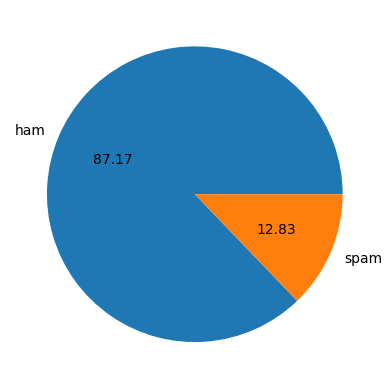

In [ ]:
plt.pie(df_train['class'].value_counts(), labels=['ham', 'spam'], autopct= "%0.2f")
plt.show()

In [ ]:
df_train['num_characters']=df_train['text'].apply(len)

In [ ]:
df_train.head()

,class,text,num_characters
0,0,ahhhh...just woken up!had a bad dream about u ...,146
1,0,you can never do nothing,24
2,0,"now u sound like manky scouse boy steve,like! ...",115
3,0,mum say we wan to go then go... then she can s...,83
4,0,never y lei... i v lazy... got wat? dat day ü ...,77


In [ ]:
df_train['num_words']=df_train['text'].apply(lambda x:len(nltk.word_tokenize(x)))
df_train['num_sentences']=df_train['text'].apply(lambda x:len(nltk.sent_tokenize(x)))
df_train.head()


,class,text,num_characters,num_words,num_sentences
0,0,ahhhh...just woken up!had a bad dream about u ...,146,38,1
1,0,you can never do nothing,24,5,1
2,0,"now u sound like manky scouse boy steve,like! ...",115,26,2
3,0,mum say we wan to go then go... then she can s...,83,19,1
4,0,never y lei... i v lazy... got wat? dat day ü ...,77,22,2


In [ ]:
df_train[['num_characters', 'num_words', 'num_sentences']].describe()

,num_characters,num_words,num_sentences
count,3935.000000,3935.000000,3935.000000
mean,79.563659,18.596188,1.879034
std,59.017209,13.460928,1.376358
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,61.000000,15.000000,1.000000
75%,119.000000,26.000000,2.000000
max,910.000000,216.000000,34.000000


In [ ]:
#ham
df_train[df_train['class']==0][['num_characters', 'num_words', 'num_sentences']].describe()

,num_characters,num_words,num_sentences
count,3430.000000,3430.000000,3430.000000
mean,70.951895,17.255394,1.736735
std,57.446782,13.681929,1.307188
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,53.000000,13.000000,1.000000
75%,91.000000,22.000000,2.000000
max,910.000000,216.000000,34.000000


In [ ]:
#spam
df_train[df_train['class']==1][['num_characters', 'num_words', 'num_sentences']].describe()

,num_characters,num_words,num_sentences
count,505.000000,505.000000,505.000000
mean,138.055446,27.702970,2.845545
std,28.310931,6.738813,1.444717
min,18.000000,2.000000,1.000000
25%,132.000000,25.000000,2.000000
50%,148.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,197.000000,46.000000,9.000000


<Axes: xlabel='num_characters', ylabel='Count'>

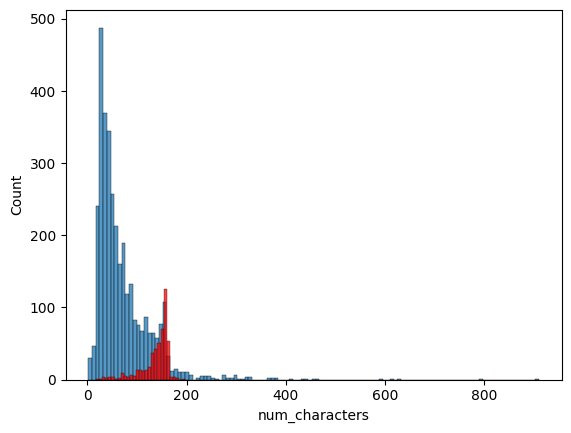

In [ ]:
import seaborn as sns
sns.histplot(df_train[df_train['class']== 0]['num_characters'])
sns.histplot(df_train[df_train['class']== 1]['num_characters'], color='red')

<Axes: xlabel='num_words', ylabel='Count'>

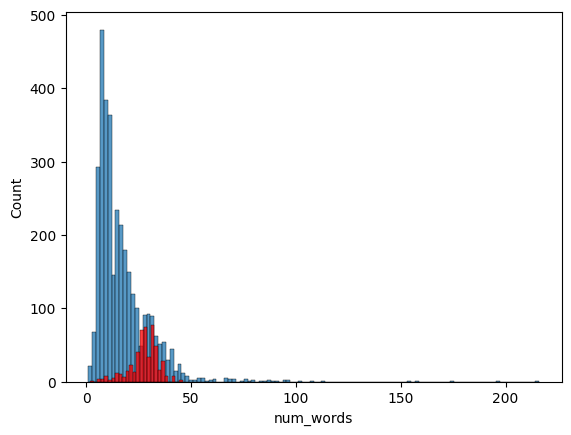

In [ ]:
sns.histplot(df_train[df_train['class']== 0]['num_words'])
sns.histplot(df_train[df_train['class']== 1]['num_words'], color='red')

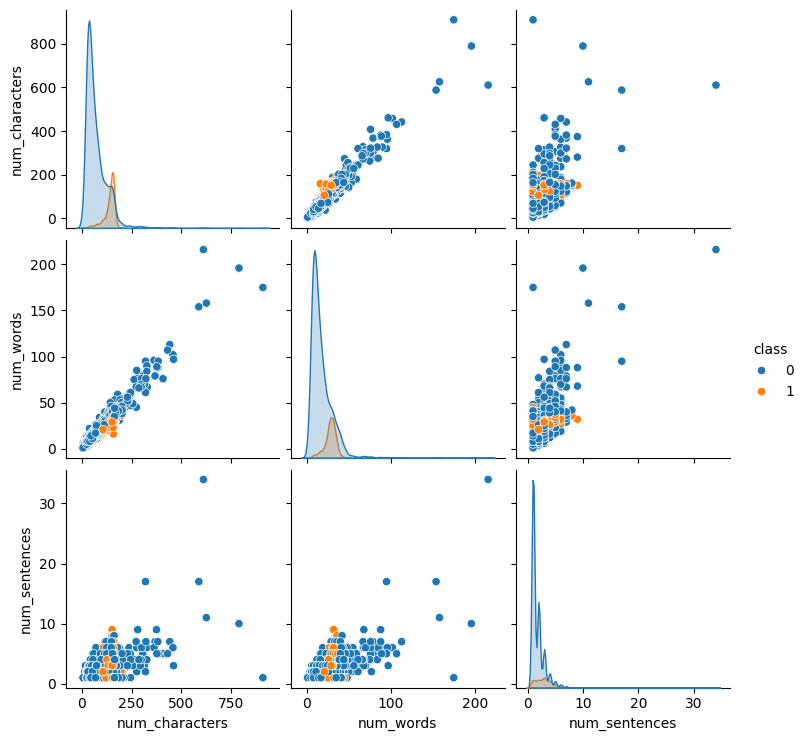

In [ ]:
sns.pairplot(df_train, hue='class')

<ipython-input-26-8f38880cce20>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_train.corr(),annot=True)


<Axes: >

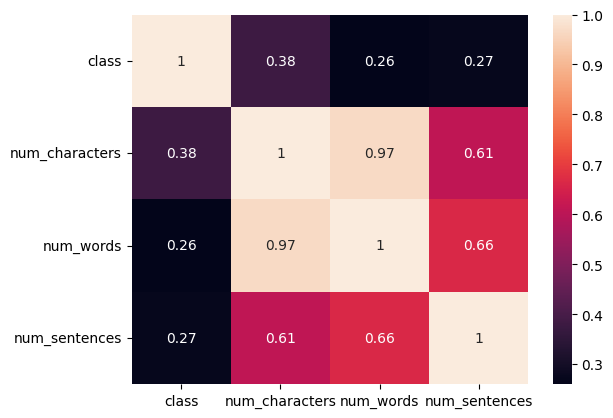

In [ ]:
sns.heatmap(df_train.corr(),annot=True)

#preprocess

In [ ]:
from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()
encoder.fit_transform(df_train['class'])
encoder.fit_transform(df_test['class'])

array([0, 0, 0, ..., 0, 0, 1])

In [ ]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords.words('english')

from nltk.stem.porter import PorterStemmer
ps= PorterStemmer()
ps.stem('loving')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


'love'

In [ ]:
def preprocess(text):
    text=text.lower()
    text=nltk.word_tokenize(text)


    y=[]
    for i in text:
      if i.isalnum():
        y.append(i)

    text=y[:]
    y.clear()

    for i in text:
      if i not in stopwords.words('english') and i not in string.punctuation:
        y.append(i)

    text= y[:]
    y.clear()

    for i in text:
      y.append(ps.stem(i))

    return " ".join(y)



In [ ]:
preprocess("you are so beautiful for me")

'beauti'

In [ ]:
df_train['text_pre']= df_train['text'].apply(preprocess)
df_test['text_pre']= df_test['text'].apply(preprocess)
df_train.head()

,class,text,num_characters,num_words,num_sentences,text_pre
0,0,ahhhh...just woken up!had a bad dream about u ...,146,38,1,ahhhh woken bad dream u tho dont like u right ...
1,0,you can never do nothing,24,5,1,never noth
2,0,"now u sound like manky scouse boy steve,like! ...",115,26,2,u sound like manki scous boy steve like travel...
3,0,mum say we wan to go then go... then she can s...,83,19,1,mum say wan go go shun bian watch da glass exh...
4,0,never y lei... i v lazy... got wat? dat day ü ...,77,22,2,never lei v lazi got wat dat day ü send da url...


#Tokenization

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer=Tokenizer(num_words=1000, oov_token='<00V>')
tokenizer.fit_on_texts(df_train['text_pre'])
word_index=tokenizer.word_index

sequences=tokenizer.texts_to_sequences(df_train['text_pre'])

padded=pad_sequences(sequences,maxlen=120, padding='post')
print(padded)
print(padded.shape)

[[  1   1 299 ...   0   0   0]
 [195 233   0 ...   0   0   0]
 [  2 288  14 ...   0   0   0]
 ...
 [ 13 375 374 ...   0   0   0]
 [ 38   1 402 ...   0   0   0]
 [ 37 299   1 ...   0   0   0]]
(3935, 120)


In [ ]:
#tokenization test data
sequences_2=tokenizer.texts_to_sequences(df_test['text_pre'])

padded_2=pad_sequences(sequences_2,maxlen= 120,padding='post')


#create the model

In [ ]:
# Definir el modelo
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=16, input_length=120)) # Ajusta 'input_dim' y 'input_length' según tus datos
model.add(GlobalAveragePooling1D())
model.add(Dense(24, activation='relu'))
model.add(Dense(1, activation='sigmoid')) # Usa 'softmax' si tienes más de dos clases

# Compilar el modelo
model.compile(optimizer='adam',
              loss='binary_crossentropy', # O 'categorical_crossentropy' para clasificación multiclase
              metrics=['accuracy'])

# Resumen del modelo
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 16)           160000    
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 160433 (626.69 KB)
Trainable params: 160433 (626.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#Train the model

In [ ]:
history = model.fit(
    padded,
    df_train['class'],
    epochs=10,
    validation_data=(padded_2, df_test['class']),
    batch_size=batch_size
)

Epoch 1/10
62/62 [==============================] - 2s 10ms/step - loss: 0.6097 - accuracy: 0.8717 - val_loss: 0.5214 - val_accuracy: 0.8695
Epoch 2/10
62/62 [==============================] - 0s 6ms/step - loss: 0.4417 - accuracy: 0.8717 - val_loss: 0.3849 - val_accuracy: 0.8695
Epoch 3/10
62/62 [==============================] - 0s 6ms/step - loss: 0.3678 - accuracy: 0.8717 - val_loss: 0.3638 - val_accuracy: 0.8695
Epoch 4/10
62/62 [==============================] - 0s 7ms/step - loss: 0.3572 - accuracy: 0.8717 - val_loss: 0.3563 - val_accuracy: 0.8695
Epoch 5/10
62/62 [==============================] - 0s 7ms/step - loss: 0.3500 - accuracy: 0.8717 - val_loss: 0.3481 - val_accuracy: 0.8695
Epoch 6/10
62/62 [==============================] - 0s 6ms/step - loss: 0.3414 - accuracy: 0.8717 - val_loss: 0.3385 - val_accuracy: 0.8695
Epoch 7/10
62/62 [==============================] - 0s 6ms/step - loss: 0.3309 - accuracy: 0.8717 - val_loss: 0.3255 - val_accuracy: 0.8695
Epoch 8/10
62/62 [=

In [ ]:
# function to predict messages based on model
def predict_message(pred_text):
    # Preprocesar el texto
    pred_text = preprocess(pred_text)  # Usa la misma función de preprocesamiento que definiste anteriormente
    # Tokenizar y padear el texto
    sequences = tokenizer.texts_to_sequences([pred_text])
    padded = pad_sequences(sequences, maxlen=120, padding='post')  # Usa el mismo 'maxlen' que para el entrenamiento

    # Predecir
    outcome = model.predict(padded)

    tag = 'ham'
    if outcome[0][0] > 0.1:
        tag = 'spam'

    prediction = [outcome[0][0], tag]

    return prediction

# Ejemplo de uso
pred_text = "I'm in a meeting, call me later at 123456789"
prediction = predict_message(pred_text)
print(prediction)


1/1 [==============================] - 0s 20ms/step
[0.09534747, 'ham']


In [ ]:
# Run this cell to test your function and model. Do not modify contents.
def test_predictions():


  test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460324",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]




  test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
  passed = True

  for msg, ans in zip(test_messages, test_answers):
    prediction = predict_message(msg)
    if prediction[1] != ans:
      passed = False

  if passed:
    print("You passed the challenge. Great job!")
  else:
    print("You haven't passed yet. Keep trying.")

test_predictions()


1/1 [==============================] - 0s 19ms/step
You passed the challenge. Great job!
